# Park-Where: Smart Parking Availability Predictor


## 1. Import modules

In [3]:
import numpy as np
import pandas as pd
import pickle
import requests

from datetime import datetime, timedelta
from parkwhere import extract_all_features
from parkwhereviz import plot_bar, plot_heatmap
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## 2. Load dataset

In [4]:
# Load CSV file as Pandas DataFrame
df = pd.read_csv("data/parking_data.csv")

# Show first 5 rows
df.head()

,date_time,parking_zone
0,19/4/2021 20:39,Zone 1
1,20/4/2021 9:12,Zone 1
2,20/4/2021 20:38,Zone 1
3,21/4/2021 8:53,Zone 1
4,21/4/2021 18:41,Zone 1


## 3. Feature engineering

In [5]:
# Convert `date_time` column into a datetime column
df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y %H:%M')

# See data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     312 non-null    datetime64[ns]
 1   parking_zone  312 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 5.0+ KB


In [6]:
print(f"Total number of records: {len(df)}")
print("Breakdown of parking zones:\n")
print(df.parking_zone.value_counts())

Total number of records: 312
Breakdown of parking zones:

Zone 1    224
Zone 4     49
Zone 2     29
Zone 3     10
Name: parking_zone, dtype: int64


In [7]:
# Create new features from `date_time` column
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['day_of_week'] = df['date_time'].dt.weekday
df['hour'] = df['date_time'].dt.hour
df['minute'] = df['date_time'].dt.minute
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.strftime('%H:%M')
df['hour_min'] = round(df['hour'] + (df['minute'] / 60), 1)

# Show first 5 rows
df.head()

,date_time,parking_zone,year,month,day,day_of_week,hour,minute,date,time,hour_min
0,2021-04-19 20:39:00,Zone 1,2021,4,19,0,20,39,2021-04-19,20:39,20.6
1,2021-04-20 09:12:00,Zone 1,2021,4,20,1,9,12,2021-04-20,09:12,9.2
2,2021-04-20 20:38:00,Zone 1,2021,4,20,1,20,38,2021-04-20,20:38,20.6
3,2021-04-21 08:53:00,Zone 1,2021,4,21,2,8,53,2021-04-21,08:53,8.9
4,2021-04-21 18:41:00,Zone 1,2021,4,21,2,18,41,2021-04-21,18:41,18.7


In [37]:
# Convert `month` to categorical
df['month'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}, inplace=True)
df['month'] = df['month'].astype('category') 
df['month'].cat.set_categories(new_categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

# Convert `day_of_week` to categorical
df['day_of_week'].replace({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
df['day_of_week'] = df['day_of_week'].astype('category') 
df['day_of_week'].cat.set_categories(new_categories=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], 
                                     ordered=True)

# Convert `hour` to categorical
df['hour'] = df['hour'].astype('category') 
df['hour'].cat.set_categories(new_categories=list(range(24)), ordered=True)

# Convert `parking_zone` to categorical
df['parking_zone'] = df['parking_zone'].astype('category') 
df['parking_zone'].cat.set_categories(new_categories=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4'], ordered=True)

# Show first 5 rows
df.head()

,date,time,month,day,day_of_week,hour,minute,hour_min,ph_eve,parking_zone
0,2021-04-19,20:39,Apr,19,Mon,20,39,20.6,nil,Zone 1
1,2021-04-20,09:12,Apr,20,Tue,9,12,9.2,nil,Zone 1
2,2021-04-20,20:38,Apr,20,Tue,20,38,20.6,nil,Zone 1
3,2021-04-21,08:53,Apr,21,Wed,8,53,8.9,nil,Zone 1
4,2021-04-21,18:41,Apr,21,Wed,18,41,18.7,nil,Zone 1


In [9]:
def parse_date(date_string):
    """Parse a date string in YYYY-MM-DD format as a datetime object."""
    
    return datetime.strptime(date_string, '%Y-%m-%d').date()

In [10]:
def get_ph_and_eve(year='2021'):
    """Return lists of parsed dates for Singapore's public holidays and public holday eves."""
    
    if year == '2021':
        url = 'https://data.gov.sg/api/action/datastore_search?resource_id=550f6e9e-034e-45a7-a003-cf7f7e252c9a&'
    
    elif year == '2022':
        url = 'https://data.gov.sg/api/action/datastore_search?resource_id=04a78f5b-2d12-4695-a6cd-d2b072bc93fe&'
    
    data = requests.get(url).json()
    ph_parsed = [parse_date(ele['date']) for ele in data['result']['records']]
    eve_parsed = [parse_date(ele['date']) - timedelta(days=1) for ele in data['result']['records']]

    return ph_parsed, eve_parsed

In [11]:
ph_parsed, eve_parsed = get_ph_and_eve(year='2021')
print(f'2021 Public Holidays: {ph_parsed}')
print()
print(f'2021 Public Holiday Eves: {eve_parsed}')

2021 Public Holidays: [datetime.date(2021, 1, 1), datetime.date(2021, 2, 12), datetime.date(2021, 2, 13), datetime.date(2021, 4, 2), datetime.date(2021, 5, 1), datetime.date(2021, 5, 13), datetime.date(2021, 5, 26), datetime.date(2021, 7, 20), datetime.date(2021, 8, 9), datetime.date(2021, 11, 4), datetime.date(2021, 12, 25)]

2021 Public Holiday Eves: [datetime.date(2020, 12, 31), datetime.date(2021, 2, 11), datetime.date(2021, 2, 12), datetime.date(2021, 4, 1), datetime.date(2021, 4, 30), datetime.date(2021, 5, 12), datetime.date(2021, 5, 25), datetime.date(2021, 7, 19), datetime.date(2021, 8, 8), datetime.date(2021, 11, 3), datetime.date(2021, 12, 24)]


In [12]:
# Create features for dates of public holidays and public holiday eves
ph, eve = get_ph_and_eve(year='2021')
df['ph'] = np.where(df['date'].isin(ph), 'ph', '')
df['eve'] = np.where(df['date'].isin(eve), 'eve', '')
df['ph_eve'] = df['ph'] + df['eve']
df['ph_eve'].replace('', 'nil', inplace=True)

# Select and rearrange columns
df = df[['date', 'time', 'month', 'day', 'day_of_week', 'hour', 
         'minute', 'hour_min', 'ph_eve', 'parking_zone']] 

# Show first 5 rows
df.head()

,date,time,month,day,day_of_week,hour,minute,hour_min,ph_eve,parking_zone
0,2021-04-19,20:39,Apr,19,Mon,20,39,20.6,nil,Zone 1
1,2021-04-20,09:12,Apr,20,Tue,9,12,9.2,nil,Zone 1
2,2021-04-20,20:38,Apr,20,Tue,20,38,20.6,nil,Zone 1
3,2021-04-21,08:53,Apr,21,Wed,8,53,8.9,nil,Zone 1
4,2021-04-21,18:41,Apr,21,Wed,18,41,18.7,nil,Zone 1


In [38]:
def extract_all_features(data, year='2021'):
    """Extract all features given a DataFrame containing a datetime string in YYYY-MM-DD HH:MM:SS format."""
    
    df = data.copy()
    df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y %H:%M')
    
    # Create new features from `date_time`
    df['year'] = df['date_time'].dt.year
    df['month'] = df['date_time'].dt.month
    df['day'] = df['date_time'].dt.day
    df['day_of_week'] = df['date_time'].dt.weekday
    df['hour'] = df['date_time'].dt.hour
    df['minute'] = df['date_time'].dt.minute
    df['date'] = df['date_time'].dt.date
    df['time'] = df['date_time'].dt.strftime('%H:%M')
    df['hour_min'] = round(df['hour'] + (df['minute'] / 60), 1)
   
    # Convert `month` to categorical
    df['month'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                         7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
    df['month'] = df['month'].astype('category') 
    df['month'].cat.set_categories(new_categories=['Jan', 'Feb', 'Mar', 
                                                   'Apr', 'May', 'Jun', 
                                                   'Jul', 'Aug', 'Sep', 
                                                   'Oct', 'Nov', 'Dec'], 
                                   ordered=True, inplace=True)

    # Convert `day_of_week` to categorical
    df['day_of_week'].replace({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
    df['day_of_week'] = df['day_of_week'].astype('category') 
    df['day_of_week'].cat.set_categories(new_categories=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], 
                                         ordered=True)

    # Convert `hour` to categorical
    df['hour'] = df['hour'].astype('category') 
    df['hour'].cat.set_categories(new_categories=list(range(24)), ordered=True)

    # Create features for dates of public holidays and public holiday eves
    ph, eve = get_ph_and_eve(year=year)
    df['ph'] = np.where(df['date'].isin(ph), 'ph', '')
    df['eve'] = np.where(df['date'].isin(eve), 'eve', '')
    df['ph_eve'] = df['ph'] + df['eve']
    df['ph_eve'].replace('', 'nil')

    # Select and rearrange columns
    try:
        df = df[['date', 'time', 'month', 'day', 'day_of_week', 'hour', 'minute', 'hour_min', 'ph_eve', 'parking_zone']] 

    except KeyError:
        df = df[['date', 'time', 'month', 'day', 'day_of_week', 'hour', 'minute', 'hour_min', 'ph_eve']] 
          
    return df

In [14]:
# Load CSV file as Pandas DataFrame
df = pd.read_csv("data/parking_data.csv")
df = extract_all_features(df, '2021')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return

## 4. Exploratory data analysis

In [15]:
import chart_studio.plotly as py
import chart_studio
import plotly.graph_objects as go

In [16]:
# Add my username
username = 'zeyalt' 

# Add my api key
api_key = 'j6vY7DJ6EPjEiEjxrIsj'  

# Set up connection to chart studio
chart_studio.tools.set_credentials_file(username = username, api_key = api_key)

In [17]:
df1 = df.replace({'eve': 'Public Holiday Eve', 'nil': 'Neither', 'ph': 'Public Holiday'})
df1.head()

,date,time,month,day,day_of_week,hour,minute,hour_min,ph_eve,parking_zone
0,2021-04-19,20:39,Apr,19,Mon,20,39,20.6,Neither,Zone 1
1,2021-04-20,09:12,Apr,20,Tue,9,12,9.2,Neither,Zone 1
2,2021-04-20,20:38,Apr,20,Tue,20,38,20.6,Neither,Zone 1
3,2021-04-21,08:53,Apr,21,Wed,8,53,8.9,Neither,Zone 1
4,2021-04-21,18:41,Apr,21,Wed,18,41,18.7,Neither,Zone 1


In [18]:
def plot_bar(data, variable, colour='cadetblue'):
    """Plot bar chart of a single variable."""
    
    mapping = {'month': 'Month', 'day_of_week': 'Day of the Week', 
               'hour': 'Hour', 'parking_zone': 'Parking Zone'}
    
    grouped_data = data.groupby(by=variable).size().reset_index(name="Count")

    fig = go.Figure()
    
    fig.add_trace(
        go.Bar(
        x = grouped_data[variable],
        y = grouped_data['Count'],
        marker_color=colour
        )
    )

    fig.update_layout(
        title="",
        xaxis_title=mapping.get(variable),
        yaxis_title="Number of Parking Sessions")

    fig.show()
    py.plot(fig, filename="by_" + variable, auto_open=True)

### 4.1. Distribution of parking sessions by months

In [19]:
plot_bar(df1, "month", colour='chocolate')

### 4.2. Distribution of parking sessions by day of the week

In [20]:
plot_bar(data=df1, variable="day_of_week", colour='forestgreen')

### 4.3. Distribution of parking sessions by hour of the day

In [21]:
plot_bar(data=df1, variable="hour", colour='maroon')

### 4.4. Distribution of parking sessions by parking zones (Class distribution)

In [22]:
plot_bar(data=df1, variable="parking_zone", colour='crimson')

### 4.5. Distribution by hour of the day and parking zones

In [23]:
def plot_stacked_bar(data, primary_var, stacking_var, by_percentage=False):
    
    if by_percentage:
        grouped_data = data.groupby(by=[primary_var, stacking_var]).size()\
                            .groupby(level=0)\
                            .apply(lambda x: round(100 * x / float(x.sum()), 1))\
                            .reset_index(name="Count")
        yaxis_label = "Percentage of Parking Sessions (%)"
    
    else:
        grouped_data = data.groupby(by=[primary_var, stacking_var]).size()\
                            .reset_index(name="Count")
        yaxis_label = "Number of Parking Sessions"
        
    mapping = {'month': 'Month', 'day_of_week': 'Day of the Week', 
               'hour': 'Hour', 'parking_zone': 'Parking Zone'}
    
    if primary_var == 'hour': 
        marker_colors = ["#6ed2b0", "#3abf91", "#2a8867", "#19513e"]

    elif primary_var == 'day_of_week':
        marker_colors = ["#e7d1a1", "#d9b568", "#ab832a", "#554115"]
        
    elif primary_var == 'ph_eve':
        marker_colors = ["#aea4e4", "#7d6dd3", "#4231a5", "#211852"]
    
    stack = data[stacking_var].unique()
    data = []
    for zone, color in zip(sorted(stack), marker_colors):
        data.append(go.Bar(name=zone, x=grouped_data[grouped_data[stacking_var] == zone][primary_var], 
                           y=grouped_data[grouped_data[stacking_var] == zone]['Count'], marker_color=color))
    fig = go.Figure(data=data)
    fig.update_layout(barmode='stack',
                      title="",
                      xaxis_title=mapping.get(primary_var),
                      yaxis_title=yaxis_label, 
                      xaxis_nticks=36)

    fig.show()
    py.plot(fig, filename=primary_var + "_stacked_by_" + stacking_var, auto_open=True)    

In [24]:
def plot_heatmap(data, variable1, variable2, colorscale="Purples"):
    """Plot heatmap of two variables."""
    
    mapping = {'month': 'Month', 'day_of_week': 'Day of the Week', 
               'hour': 'Hour', 'parking_zone': 'Parking Zone'}
    
    heatmap_data = data.groupby(by=[variable1, variable2])["date"].count().to_frame('Count').reset_index()
    heatmap_data = heatmap_data.pivot(index=variable1, columns=variable2, values="Count")

    fig = go.Figure(data=go.Heatmap(
            z=heatmap_data,
            x=heatmap_data.columns,
            y=heatmap_data.index,
            colorscale=colorscale))

    fig.update_layout(
        title="",
        xaxis_title=mapping.get(variable2),
        yaxis_title=mapping.get(variable1), 
        xaxis_nticks=36)

    fig.show()
#     py.plot(fig, filename=variable1 + "_by_" + variable2, auto_open=True)

In [25]:
plot_heatmap(df1, 'parking_zone', 'hour')
plot_stacked_bar(df1, 'hour', 'parking_zone', by_percentage=True)

### 4.6. Distribution by day of the week and parking zones

In [26]:
plot_heatmap(df1, 'parking_zone', 'day_of_week')
plot_stacked_bar(df1, 'day_of_week', 'parking_zone', by_percentage=True)

### 4.7. Public holiday, eve, or neither?

In [27]:
plot_heatmap(df1, 'parking_zone', 'ph_eve')
plot_stacked_bar(df1, 'ph_eve', 'parking_zone', by_percentage=True)

### 4.8. Heatmap of day of the week by month

In [28]:
plot_heatmap(data=df1, variable1="day_of_week", variable2="month", colorscale="Blues")

### 4.9. Heatmap of day of the week by hour

In [29]:
plot_heatmap(data=df1, variable1="day_of_week", variable2="hour", colorscale="Oranges")

### 6. Building a baseline model

In [30]:
# Make a copy of `df`
train_df = df.copy()

# Select features
train_df = train_df[["hour_min", "day_of_week", "ph_eve", "parking_zone"]]

# Group Zones 2, 3, and 4 as 'Other Zones'
train_df['parking_zone'].replace(['Zone 2', 'Zone 3', 'Zone 4'], 'Other Zones')

# Show first 5 rows
train_df.head()

,hour_min,day_of_week,ph_eve,parking_zone
0,20.6,Mon,nil,Zone 1
1,9.2,Tue,nil,Zone 1
2,20.6,Tue,nil,Zone 1
3,8.9,Wed,nil,Zone 1
4,18.7,Wed,nil,Zone 1


In [31]:
# Create a `Pipeline` object with `StandardScaler` for numerical feature
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# Create a `OneHotEncoder` object for categorical features 
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Create a `ColumnTransfomer` object 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["hour_min"]),
        ("cat", categorical_transformer, ["day_of_week", "ph_eve"]),
    ]
)

# Append a Logistic Regression classifier
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [32]:
# Split data into features and target variable
X = train_df.drop(columns='parking_zone')
y = train_df['parking_zone']

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the full prediction pipeline to the training data
clf.fit(X_train, y_train)

# Generate predictions on validation data
y_pred = clf.predict(X_test)

# View classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Zone 1       0.77      0.98      0.86        41
      Zone 2       0.00      0.00      0.00         6
      Zone 3       0.00      0.00      0.00         1
      Zone 4       0.80      0.53      0.64        15

    accuracy                           0.76        63
   macro avg       0.39      0.38      0.38        63
weighted avg       0.69      0.76      0.71        63



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [33]:
# Adapted from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Class')
    plt.xlabel('Predicted Class\n\nAccuracy = {:0.3f}\nError Rate = {:0.3f}'.format(accuracy, misclass))
    plt.show()

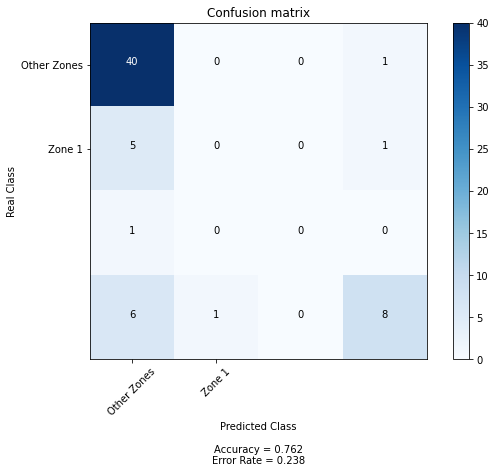

In [34]:
plot_confusion_matrix(cm=confusion_matrix(y_test, y_pred), 
                      target_names=['Other Zones', 'Zone 1'], 
                      normalize=False)

In [35]:
# Saving the model
filename = 'model/model.sav'
pickle.dump(clf, open(filename, 'wb'))

### 7. Generating inferences

In [36]:
# Sample date and time inputs 
# date, time = '2022-01-12', '16:05'
date, time = '12/01/2022', '22:05'

# Save input as a DataFrame
predict_df = pd.DataFrame({'date_time': date + ' ' + time}, index=[0])
predict_df['date_time'] = pd.to_datetime(predict_df['date_time'])
predict_df = extract_all_features(predict_df, '2022')
predict_df = predict_df[['hour_min', 'day_of_week', 'ph_eve']]

# Generate predictions
print(f"Predicted parking zone: {clf.predict(predict_df)[0]}")
print(f"Predicted probabilities: {clf.predict_proba(predict_df)[0]}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning:

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning:

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning:

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.



Predicted parking zone: Zone 4
Predicted probabilities: [0.19007575 0.09203559 0.0960041  0.62188457]
